# Compare with experiment 1, this experiment (epx2) just changes the black samples selection

# Here, black samples are those SELLER-SCAM ATO cases

In [ ]:
# data source
data_file = '/Users/jiangyi.wang/Desktop/Desktop - LAZ-SG-L-M-1109/Account Takeover/login v2/experiment/exp2/seller_scam_login_sample_feature_v2_1657173615653.txt'
# define venture, entrance (all entrance)
venture = 'ID'


# define whether to display feature importance, shap or PR curve on test data
is_grid_search, is_feature_importance, is_shap, is_plot_pr = True, True, True, True
# define whether to skip some sections, False means do not run that part
is_save_model, is_plot_interactive_pr, is_plot_thrhld_bin, is_comparision_w_old_model = False, True, True, True

# model feature list
features_to_use = ['no_unique_umid_14d',
                  'no_unique_ip2_14d',
                  'id_new_ip3_4m',
                  'id_ip3_same_seller_14d',
                  'avg_price_per_order_14d',
                  'std_price_per_order_14d',
                  'avg_dscnt_rate_per_order_14d',
                  'std_dscnt_rate_per_order_14d',
                  'avg_shpfee_per_order_14d',
                  'std_shpfee_per_order_14d',
                  'id_susp_paymethod_14d',
                  'no_acct_umid_14d',
                  'max_cancel_rate_14d',
                  'max_avg_price_seller_14d',
                  'max_avg_dscnt_rate_seller_14d',
                  'max_avg_shpfee_seller_14d'
                     ]

# for EDA
features_type = [False,
                 False,
                 True,
                 True,
                 False,
                 False,
                 False,
                 False,
                 False,
                 False,
                 True,
                 False,
                 False,
                 False,
                 False,
                 False
                ]

byr_idx_cols = ['label', 'buyer_id']

# feature list that needs to impute
features_to_impute = ['no_unique_umid_14d',
                  'no_unique_ip2_14d',
                  'id_new_ip3_4m',
                  'id_ip3_same_seller_14d',
                  'avg_price_per_order_14d',
                  'std_price_per_order_14d',
                  'avg_dscnt_rate_per_order_14d',
                  'std_dscnt_rate_per_order_14d',
                  'avg_shpfee_per_order_14d',
                  'std_shpfee_per_order_14d',
                  'id_susp_paymethod_14d',
                  'no_acct_umid_14d',
                  'max_cancel_rate_14d',
                  'max_avg_price_seller_14d',
                  'max_avg_dscnt_rate_seller_14d',
                  'max_avg_shpfee_seller_14d'
                     ]

# model candidates
model_list = ['rf', 'xgb']


# params of model
rf_default_param = {'bootstrap': True, 'oob_score': True, 'max_depth':10, 'n_estimators': 120, 'criterion':'gini',
             'n_jobs': -1, 'random_state': 0
               , 'class_weight': 'balanced'
            }

rf_param_grid = {
            'max_depth': [2, 8, 16],
            'n_estimators': [32, 64, 128],
            'min_samples_leaf' : [5, 20, 30],
            'bootstrap': [True], 
            'oob_score': [True], 
            'criterion':['gini'],
            'random_state': [0], 
            'class_weight': ['balanced']
            }    

xgb_default_param = {'verbosity':0, 'n_jobs': -1, 'random_state':0}
xgb_param_grid = {
            'min_child_weight': [1, 5, 10],
            'gamma': [0.5, 1, 1.5, 2, 5],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'max_depth': [3, 5, 10],
            'verbosity':[0],
            'use_label_encoder':[False],
            'random_state': [0]
            }              

model_params = {'rf': [rf_default_param, rf_param_grid],
                'xgb': [xgb_default_param, xgb_param_grid]
               }

# seed for generating the training / testing set
random_state = 42
test_size = 0.2
cv = 5
threshold_setting = 0.5

# Import packages

In [5]:
# Import packages%pip install xgboost
%pip install shap
%pip install plotly
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
import plotly.express as px

import json
import numpy as np
import pandas as pd
from datetime import datetime, timezone, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import recall_score, precision_score, accuracy_score, confusion_matrix, precision_recall_curve, f1_score, roc_auc_score
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import RandomizedSearchCV
import shap

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Functions

In [6]:
# function to reduce data size
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


# function to plot PR curve
## input ground-truth label and predicted label
### return PR-curve and corresponding threshold, precison, record, f1-scores
def plot_pr(y, pred):
    # based on different thresholds
    precision, recall, thresholds = precision_recall_curve(y, pred)

    f1_scores = []
    for i in range(len(thresholds)):
        f1_scores.append(2*recall[i]*precision[i]/(recall[i]+precision[i]))
    
    # select the best model according to the f1-score
    ix = np.argmax(f1_scores)
#     print('Best threshold: ', thresholds[ix])
#     print('Best F1-Score: ', np.max(f1_scores))

    fig, ax = plt.subplots()
    ax.plot(recall, precision)
    ax.scatter(recall[ix], precision[ix], marker='o', color='red', label='Best')

    # add axis labels to plot
    ax.set_title('Precision-Recall Curve')
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')
    plt.show()

    return thresholds[ix], precision, recall, thresholds, f1_scores


# fucntion to display EDA
## col2 represents the label
### col1 reprensts the features
#### is_cat = True, then histogram; is_cat = False, then density figure
def display_kdeplot(df, col1, col2, is_cat):
    df[col1] = df[col1].astype(float)
    plt.figure(figsize = (15, 6))
    if is_cat:
        sns.countplot(data = df, x = col1, hue = col2)
    else:
        ax = plt.axes()
        sns.kdeplot(data = df[df[col2] == 0], x = col1, color = 'darkorange', label = 'Non-ATO')
        ax_bis = ax.twinx()
        sns.kdeplot(data = df[df[col2] == 1], x = col1, label = 'ATO')
        plt.title(col1)
        ax.legend(loc = 'upper left')
        ax_bis.legend(loc = 'upper right')
        # ax.set_xscale('log')
    plt.show
    
    print(df.groupby(col2)[col1].describe())
    print(col1)
    
## Training funcitons--------------------------------------------------------------------------------------------

# given total data, feature list, testing set parameter
## return corresponding training and testing set
def train_test_generation(df, features_to_use, byr_idx_cols, test_size, random_state):
    feature_list = byr_idx_cols + features_to_use
    # only select the features we need
    df = df[feature_list].astype(float)
    
    y = df['label']
    
    df_train, df_test, y_train, y_test = train_test_split(df, y, test_size = test_size, random_state = random_state)
    
    X_train, X_test = df_train[features_to_use], df_test[features_to_use]
    
    return X_train, y_train, X_test, y_test, df_test

# given ground-truth label and predicted label
## return all performance metric
def display_model_metrics(y, y_pred):
    print('     F1 score:', f1_score(y, y_pred))
    print('     AUC:', roc_auc_score(y, y_pred))
    print('     Accuracy:', accuracy_score(y, y_pred))
    print('     Precision:', precision_score(y, y_pred))
    print('     Recall:', recall_score(y, y_pred))
    print("\tConfusion matrix：\n", confusion_matrix(y, y_pred))
    
# given model (non-parametrized classifier), grid parameters, cross-valdiation folds, dataset
## return best parameters
def model_grid_search(is_grid_search, clf_gs, param_grid, default_param, cv, x, y):
    if is_grid_search:
        grid_search = GridSearchCV(estimator = clf_gs,
                                  param_grid = param_grid,
                                  scoring = 'roc_auc',
                                  cv = cv,
                                  verbose = 1,
                                  n_jobs = 1
                                  )
        grid_search.fit(x, y)
        best_param = grid_search.best_params_
    else:
        best_param = default_param
        
    print('====> grid search parameters: \n{')
    [print(key,':',value) for key, value in param_grid.items()]
    print('}\n')
        
    print('====> best estimator: \n{')
    [print(key,':',value) for key, value in best_param.items()]
    print('}\n')
    
    return best_param


# given parametrized model, splited data (training + testing), threshold (for confusion matrix) and
# feature list (for feature importance),
## return feature importance, training and testing confusion matrix, shapley value, PR-curve and 
## probability prediction
def model_train(mod, X_train, y_train, X_test, y_test, 
                threshold, features_to_use,
                is_feature_importance, is_shap, is_plot_pr):
    
    mod.fit(X_train, y_train)
    
    # model prediction on training set
    y_train_preds = mod.predict(X_train)
    y_train_preds_prob = mod.predict_proba(X_train)
    train_preds = [1 if y_train_preds_prob[i][1] > threshold else 0 for i in range(len(y_train_preds_prob))]
    print("=============================================================")
    print(f'Train:')
    print('Label distribution:\n{}\n'.format(y_train.value_counts()))
    display_model_metrics(y_train, train_preds)
    
    # model prediction on testing set
    y_test_preds = mod.predict(X_test)
    y_test_preds_prob = mod.predict_proba(X_test)
    test_preds = [1 if y_test_preds_prob[i][1] > threshold else 0 for i in range(len(y_test_preds_prob))]
    print("\n=============================================================")
    print('Testing:')
    print('Label distribution:\n{}\n'.format(y_test.value_counts()))
    display_model_metrics(y_test, test_preds)
    
    output_list = [mod]

    
    # feature importance
    if is_feature_importance is True:
        print("=============================================================")
        print(pd.DataFrame({'feature': list(features_to_use),
               'importance': mod.feature_importances_}).\
                sort_values('importance', ascending = False))
    # shapley value
    if is_shap is True:
        print("=============================================================")
        print('SHAP explanation: \n')
        explainer = shap.TreeExplainer(mod)
        shap_values = explainer.shap_values(X_test)
        try: 
            shap.summary_plot(shap_values[1], X_test, max_display=30)
        except:
            shap.summary_plot(shap_values, X_test, max_display=30)
    # precision-recall curve
    if is_plot_pr is True:
        print("=============================================================")
        thres, precision, recall, thresholds, f1_scores = plot_pr(y_test, y_test_preds_prob[:, 1])
        output_list.append([thres, precision, recall, thresholds, f1_scores])
    
    output_list.append(y_test_preds_prob[:,1])
    
    return output_list


# Main function to cover all model training details
## Given dataset and random seed (random state), first generating training and testing set
### then use cv to achieve best parameters
#### finally use best parmaters to achieve model performance
def run_model(df, features_to_use, byr_idx_cols, cv,
              model_name, model_param, threshold, 
              is_grid_search, is_feature_importance, is_shap, is_plot_pr, test_size, random_state):
    
    X_train, y_train, X_test, y_test, df_test = train_test_generation(df, features_to_use, byr_idx_cols,
                                                                test_size, random_state)
    
    
    # model training
    x, y = X_train, y_train

    # RF
    if model_name == 'rf':
        print('=============================================================')
        print('                    Random forest model                      ')
        print('=============================================================')
        
        # grid search
        clf_gs = RandomForestClassifier()
        best_param = model_grid_search(is_grid_search, clf_gs, model_param[1], model_param[0], cv, x, y)
        clf = RandomForestClassifier(**best_param)
        
    # xgboost
    elif model_name == 'xgb':
        print('=============================================================')
        print('                      Xgboost model                          ')
        print('=============================================================')
        # grid search
        clf_gs = xgb.XGBClassifier()   
        best_param = model_grid_search(is_grid_search, clf_gs, model_param[1], model_param[0], cv, x, y)
        clf = xgb.XGBClassifier(**best_param)   
        
                
    output_list = model_train(clf, X_train, y_train, X_test, y_test, threshold,
                                  features_to_use, is_feature_importance, is_shap, is_plot_pr,
                                 )

    return output_list

# Main Code

## 1. Load Data

In [7]:
df = pd.read_csv(data_file, delimiter = ',', dtype = str)
df['label'] = df['label'].astype(float)
df.head()

,buyer_id,label,no_unique_umid_14d,no_unique_ip2_14d,id_new_ip3_4m,id_ip3_same_seller_14d,avg_price_per_order_14d,std_price_per_order_14d,avg_dscnt_rate_per_order_14d,std_dscnt_rate_per_order_14d,avg_shpfee_per_order_14d,std_shpfee_per_order_14d,id_susp_paymethod_14d,no_acct_umid_14d,max_cancel_rate_14d,max_avg_price_seller_14d,max_avg_dscnt_rate_seller_14d,max_avg_shpfee_seller_14d
0,10608942,0.0,2,4,1,0,\N,\N,\N,\N,\N,\N,\N,0,\N,\N,\N,\N
1,10779984,0.0,2,1,0,0,34900.0,0.0,0.0,0.0,6900.0,0.0,0,1,0.11202735317779565,12092.021107862378,0.5768609158123034,2956.9723234669764
2,1124333,0.0,1,1,1,0,182.57142857142858,61.985844335293066,0.0,0.0,48.42857142857143,15.927129979621409,\N,1,\N,\N,\N,\N
3,11289976,0.0,0,0,0,0,\N,\N,\N,\N,\N,\N,\N,1,\N,\N,\N,\N
4,11721883,0.0,2,5,0,0,45466.5,5233.5,0.0,0.0,6900.0,0.0,0,1,0.12882402469828796,41695.30326797385,0.7412961020572922,16773.2091503268


## 2.impute null values with 0

In [8]:
df = df.replace('\\N', 0)
df[features_to_impute] = df[features_to_impute].astype(float)
df.head()

,buyer_id,label,no_unique_umid_14d,no_unique_ip2_14d,id_new_ip3_4m,id_ip3_same_seller_14d,avg_price_per_order_14d,std_price_per_order_14d,avg_dscnt_rate_per_order_14d,std_dscnt_rate_per_order_14d,avg_shpfee_per_order_14d,std_shpfee_per_order_14d,id_susp_paymethod_14d,no_acct_umid_14d,max_cancel_rate_14d,max_avg_price_seller_14d,max_avg_dscnt_rate_seller_14d,max_avg_shpfee_seller_14d
0,10608942,0.0,2.0,4.0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,10779984,0.0,2.0,1.0,0.0,0.0,34900.000000,0.000000,0.0,0.0,6900.000000,0.00000,0.0,1.0,0.112027,12092.021108,0.576861,2956.972323
2,1124333,0.0,1.0,1.0,1.0,0.0,182.571429,61.985844,0.0,0.0,48.428571,15.92713,0.0,1.0,0.000000,0.000000,0.000000,0.000000
3,11289976,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0,1.0,0.000000,0.000000,0.000000,0.000000
4,11721883,0.0,2.0,5.0,0.0,0.0,45466.500000,5233.500000,0.0,0.0,6900.000000,0.00000,0.0,1.0,0.128824,41695.303268,0.741296,16773.209150


## 3. Percentage of Black Samples

In [9]:
bl_cnt = (df.label==1).astype(float).sum()
total = (df.label!=-1).astype(float).sum()
percent = round((bl_cnt / total)*100, 2)

print(bl_cnt, 'black samples out of a total of', total, 'samples.')
print('Black sample percent: ' +  str(percent) + '%')

524.0 black samples out of a total of 2024.0 samples.
Black sample percent: 25.89%


In [10]:
df_feature = reduce_mem_usage(df)

Memory usage of dataframe is 0.28 MB
Memory usage after optimization is: 0.17 MB
Decreased by 38.4%


In [11]:
df_feature.head()

,buyer_id,label,no_unique_umid_14d,no_unique_ip2_14d,id_new_ip3_4m,id_ip3_same_seller_14d,avg_price_per_order_14d,std_price_per_order_14d,avg_dscnt_rate_per_order_14d,std_dscnt_rate_per_order_14d,avg_shpfee_per_order_14d,std_shpfee_per_order_14d,id_susp_paymethod_14d,no_acct_umid_14d,max_cancel_rate_14d,max_avg_price_seller_14d,max_avg_dscnt_rate_seller_14d,max_avg_shpfee_seller_14d
0,10608942,0.0,2.0,4.0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,10779984,0.0,2.0,1.0,0.0,0.0,34900.000000,0.000000,0.0,0.0,6900.00000,0.00000,0.0,1.0,0.112000,12092.021484,0.576660,2956.972412
2,1124333,0.0,1.0,1.0,1.0,0.0,182.571426,61.985844,0.0,0.0,48.42857,15.92713,0.0,1.0,0.000000,0.000000,0.000000,0.000000
3,11289976,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.00000,0.0,1.0,0.000000,0.000000,0.000000,0.000000
4,11721883,0.0,2.0,5.0,0.0,0.0,45466.500000,5233.500000,0.0,0.0,6900.00000,0.00000,0.0,1.0,0.128784,41695.304688,0.741211,16773.208984


## 4. visualization (EDA)

In [12]:
# check unique value count within every feature
pd.set_option('display.max_rows', 200)
df_feature[features_to_use].apply(pd.Series.nunique)

no_unique_umid_14d                14
no_unique_ip2_14d                  9
id_new_ip3_4m                      2
id_ip3_same_seller_14d             2
avg_price_per_order_14d          999
std_price_per_order_14d          608
avg_dscnt_rate_per_order_14d     260
std_dscnt_rate_per_order_14d     166
avg_shpfee_per_order_14d         581
std_shpfee_per_order_14d         480
id_susp_paymethod_14d              2
no_acct_umid_14d                  48
max_cancel_rate_14d              463
max_avg_price_seller_14d         986
max_avg_dscnt_rate_seller_14d    673
max_avg_shpfee_seller_14d        850
dtype: int64

        count      mean       std  min  25%  50%  75%   max
label                                                      
0.0    1500.0  0.808667  1.277946  0.0  0.0  1.0  1.0  19.0
1.0     524.0  1.047710  0.295949  0.0  1.0  1.0  1.0   3.0
------------------------------------------------------------------------
        count      mean       std  min  25%  50%  75%  max
label                                                     
0.0    1500.0  1.115333  1.273491  0.0  0.0  1.0  2.0  8.0
1.0     524.0  2.633588  1.463154  0.0  2.0  2.0  3.0  8.0
------------------------------------------------------------------------
        count      mean       std  min  25%  50%  75%  max
label                                                     
0.0    1500.0  0.592000  0.491627  0.0  0.0  1.0  1.0  1.0
1.0     524.0  0.950382  0.217363  0.0  1.0  1.0  1.0  1.0
------------------------------------------------------------------------
        count      mean       std  min  25%  50%  75%  max
label     

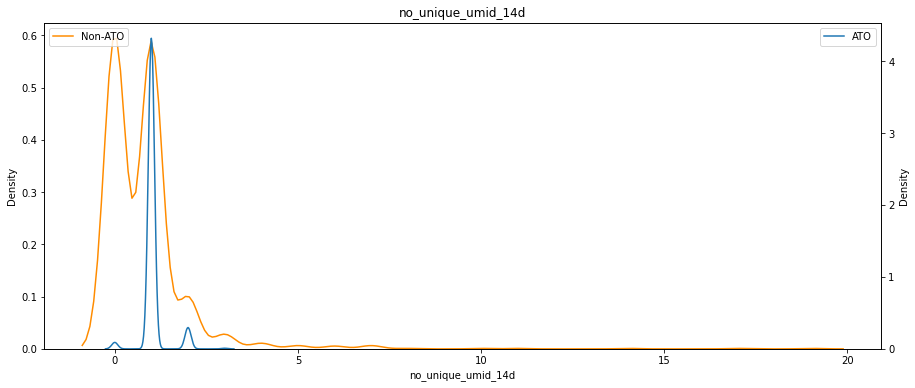

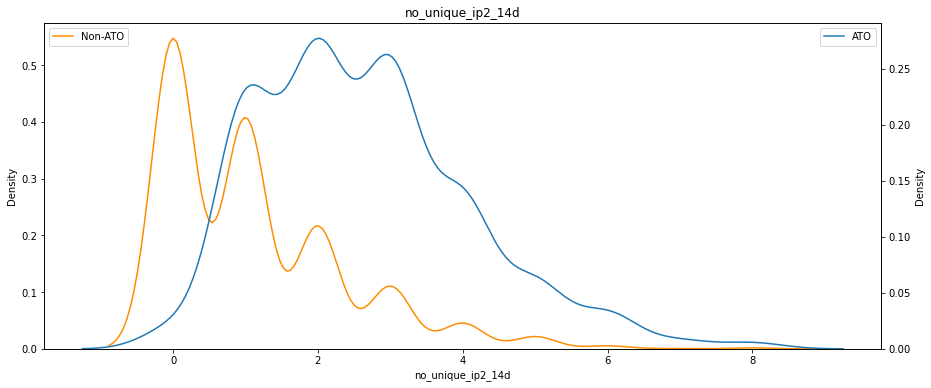

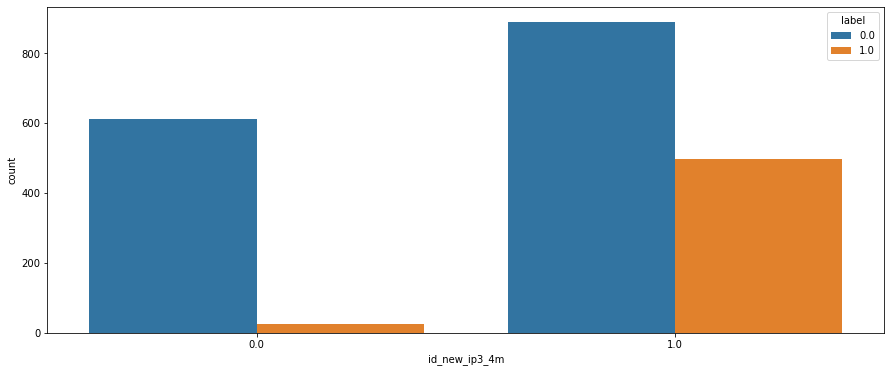

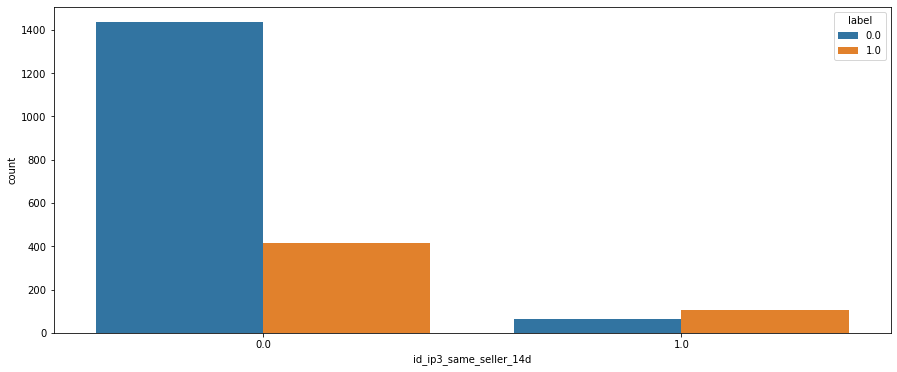

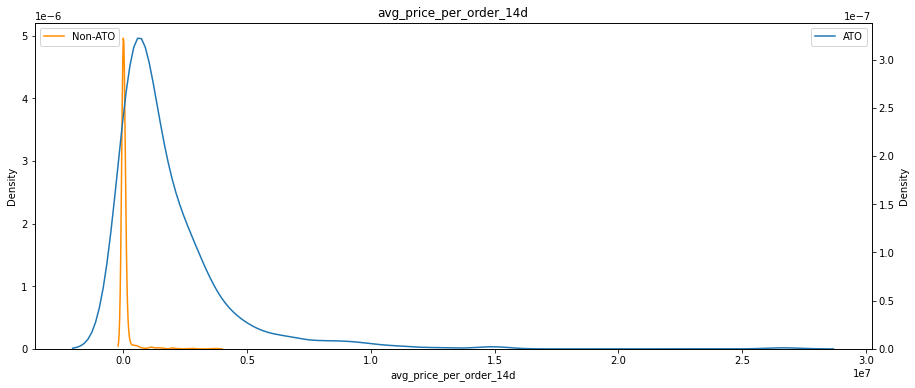

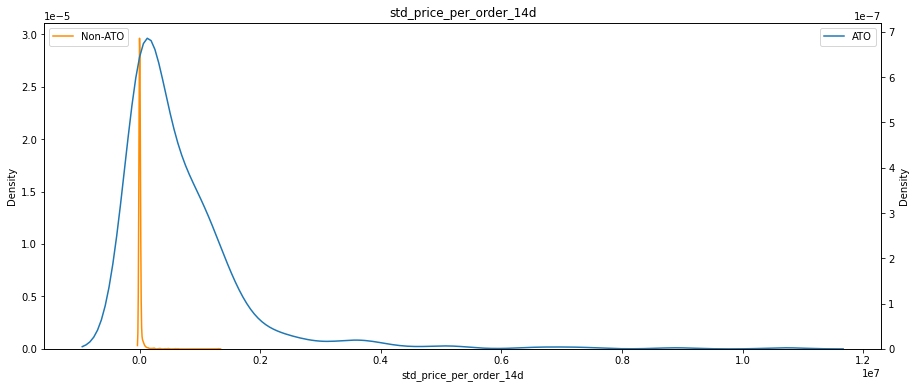

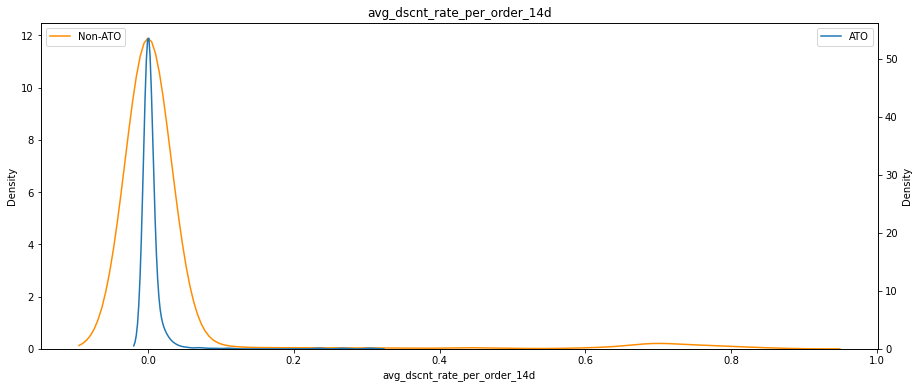

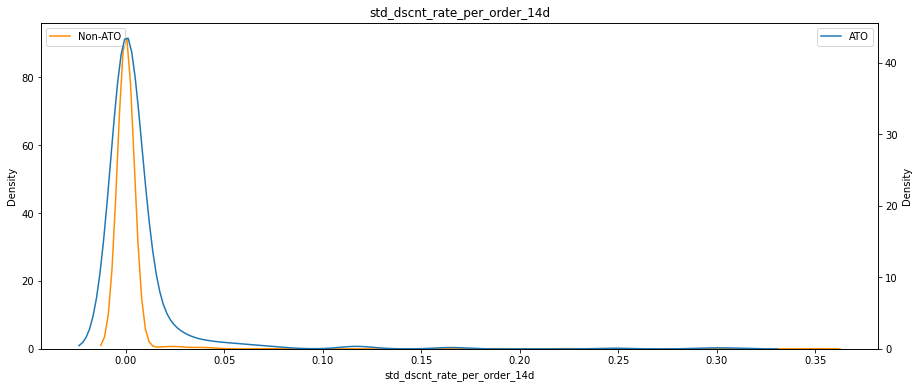

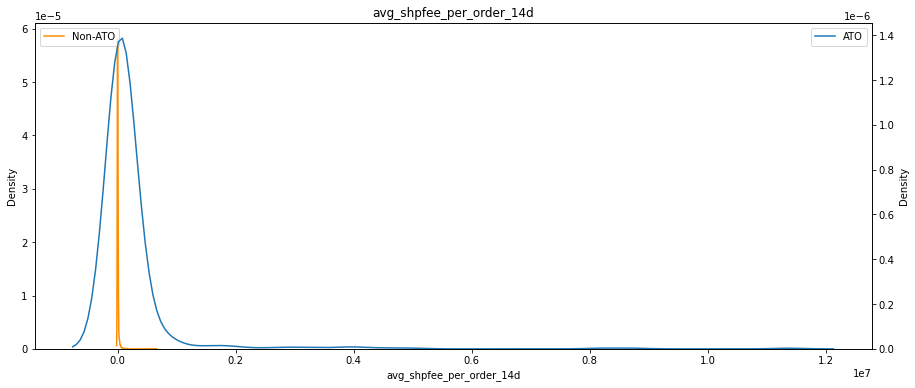

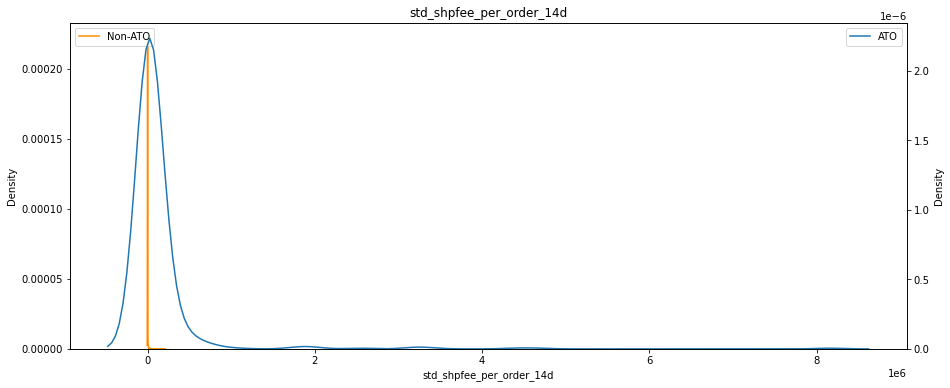

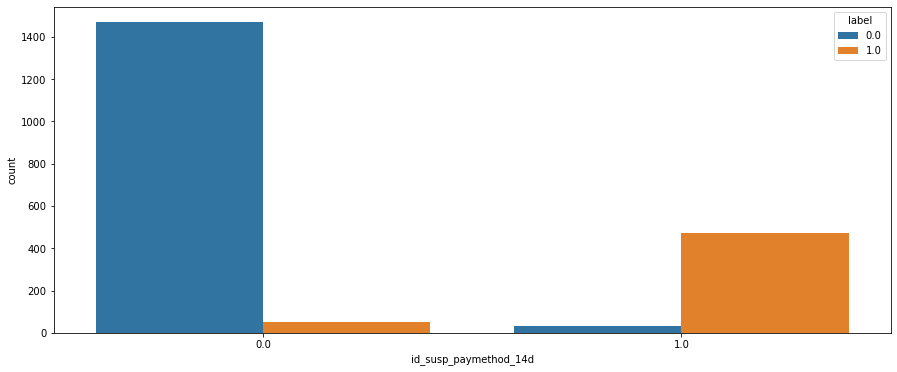

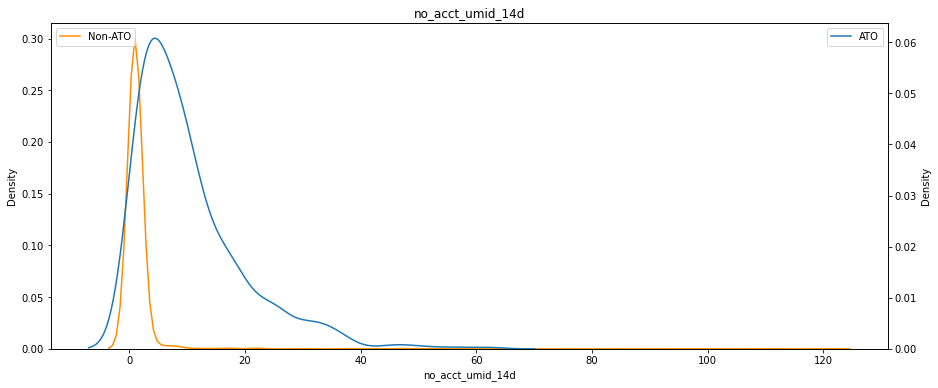

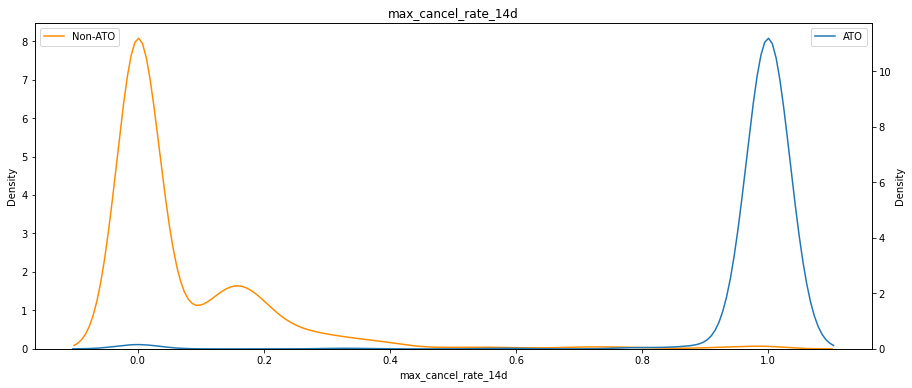

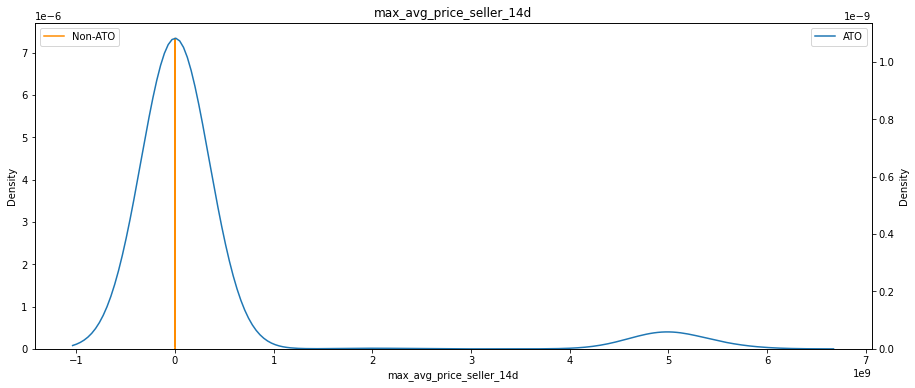

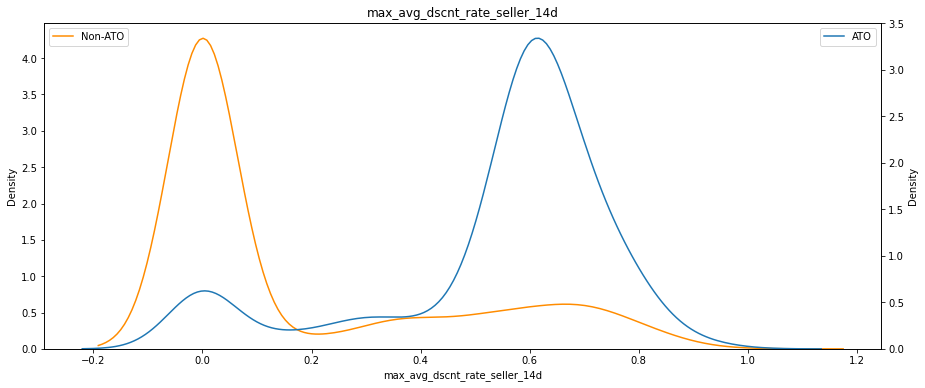

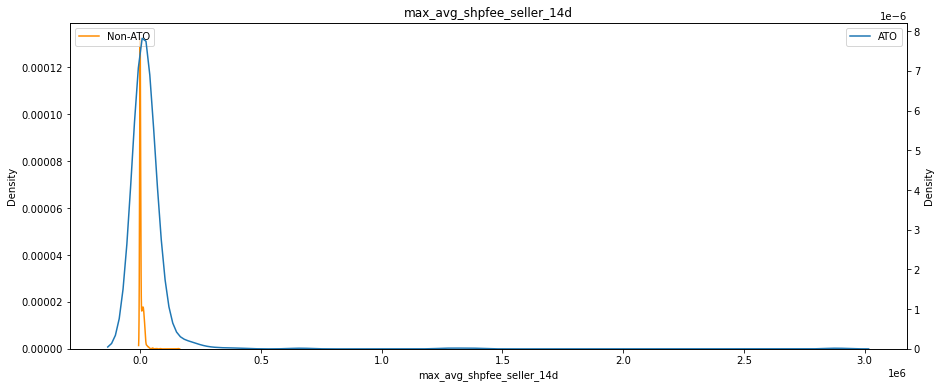

In [13]:
for i in range(len(features_to_use)):
    feature_name = features_to_use[i]
    feature_type = features_type[i]
    display_kdeplot(df_feature, feature_name, 'label', feature_type)
    print('------------------------------------------------------------------------')

## 5. Model training

                    Random forest model                      
Fitting 5 folds for each of 27 candidates, totalling 135 fits
====> grid search parameters: 
{
max_depth : [2, 8, 16]
n_estimators : [32, 64, 128]
min_samples_leaf : [5, 20, 30]
bootstrap : [True]
oob_score : [True]
criterion : ['gini']
random_state : [0]
class_weight : ['balanced']
}

====> best estimator: 
{
bootstrap : True
class_weight : balanced
criterion : gini
max_depth : 8
min_samples_leaf : 5
n_estimators : 32
oob_score : True
random_state : 0
}

Train:
Label distribution:
0.0    1204
1.0     415
Name: label, dtype: int64

     F1 score: 0.9915560916767189
     AUC: 0.9939348757154867
     Accuracy: 0.9956763434218654
     Precision: 0.9927536231884058
     Recall: 0.9903614457831326
	Confusion matrix：
 [[1201    3]
 [   4  411]]

Testing:
Label distribution:
0.0    296
1.0    109
Name: label, dtype: int64

     F1 score: 0.9814814814814815
     AUC: 0.9845493429209025
     Accuracy: 0.9901234567901235
     Precisio

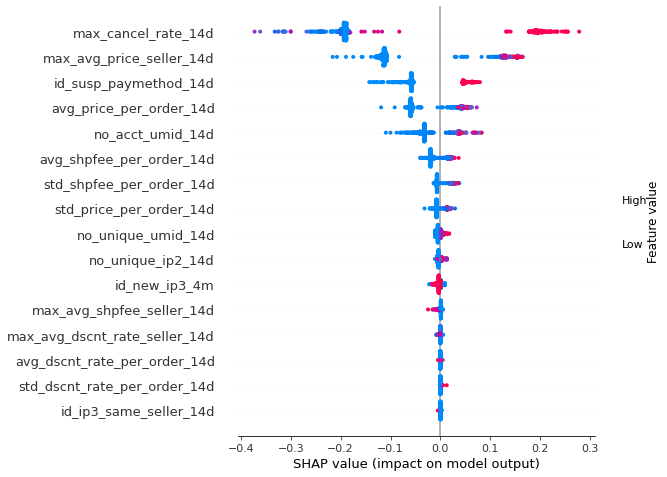

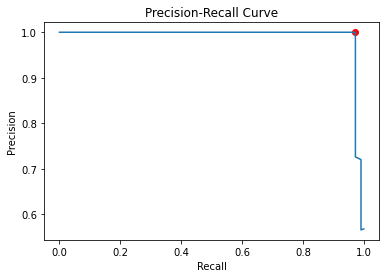

                      Xgboost model                          
Fitting 5 folds for each of 405 candidates, totalling 2025 fits
====> grid search parameters: 
{
min_child_weight : [1, 5, 10]
gamma : [0.5, 1, 1.5, 2, 5]
subsample : [0.6, 0.8, 1.0]
colsample_bytree : [0.6, 0.8, 1.0]
max_depth : [3, 5, 10]
verbosity : [0]
use_label_encoder : [False]
random_state : [0]
}

====> best estimator: 
{
colsample_bytree : 0.8
gamma : 0.5
max_depth : 3
min_child_weight : 1
random_state : 0
subsample : 0.8
use_label_encoder : False
verbosity : 0
}

Train:
Label distribution:
0.0    1204
1.0     415
Name: label, dtype: int64

     F1 score: 0.9951573849878934
     AUC: 0.9951807228915663
     Accuracy: 0.9975293390982087
     Precision: 1.0
     Recall: 0.9903614457831326
	Confusion matrix：
 [[1204    0]
 [   4  411]]

Testing:
Label distribution:
0.0    296
1.0    109
Name: label, dtype: int64

     F1 score: 0.9814814814814815
     AUC: 0.9845493429209025
     Accuracy: 0.9901234567901235
     Preci

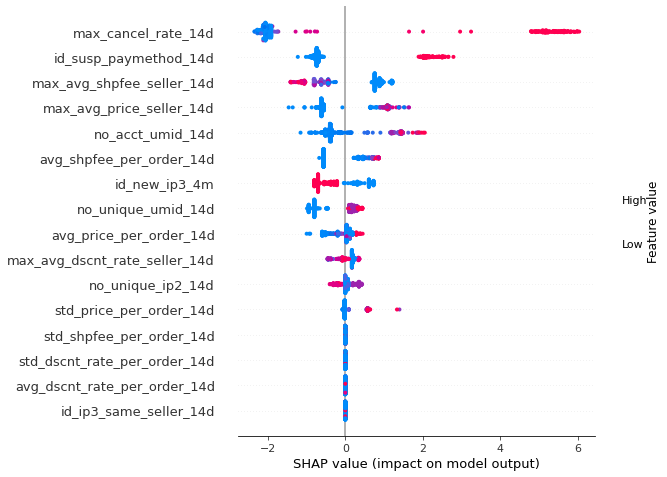

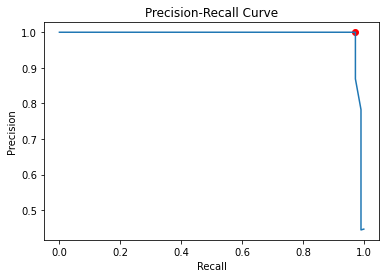

In [14]:
# Run models
res = {}
# generate the dataset to save the model result (df_test)
X_train, y_train, X_test, y_test, df_test = train_test_generation(df_feature, features_to_use, byr_idx_cols,
                                 test_size, random_state)
df_test = df_test.astype(float)
df_test['buyer_id'] = df_test['buyer_id'].astype(str)

for model in model_list:
    res_m = run_model(df_feature, features_to_use, byr_idx_cols, cv,
                     model, model_params[model], threshold_setting, 
                     is_grid_search, is_feature_importance, is_shap, is_plot_pr, test_size, random_state)
    res[model] = res_m
    # res_m[-2] -> parameters for PR-curve (metric and corresponding threshold)
    # res_m[-1] -> probability prediction for testing sample
    df_test[model+'_pred'] = res_m[-1]

In [15]:
df_test.head()

,label,buyer_id,no_unique_umid_14d,no_unique_ip2_14d,id_new_ip3_4m,id_ip3_same_seller_14d,avg_price_per_order_14d,std_price_per_order_14d,avg_dscnt_rate_per_order_14d,std_dscnt_rate_per_order_14d,avg_shpfee_per_order_14d,std_shpfee_per_order_14d,id_susp_paymethod_14d,no_acct_umid_14d,max_cancel_rate_14d,max_avg_price_seller_14d,max_avg_dscnt_rate_seller_14d,max_avg_shpfee_seller_14d,rf_pred,xgb_pred
1251,0.0,410422632096.0,0.0,4.0,1.0,0.0,16321.000000,0.000000,0.0,0.0,13500.000000,0.000000,0.0,0.0,0.168457,26358.482422,0.219727,8261.488281,0.000000,0.000217
1583,1.0,400012480632.0,1.0,3.0,1.0,0.0,149380.421875,31790.441406,0.0,0.0,12642.857422,9549.548828,0.0,34.0,1.000000,190060.484375,0.538574,19222.376953,0.956175,0.990815
721,0.0,400347177253.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,2.0,0.000000,0.000000,0.000000,0.000000,0.000924,0.000592
591,0.0,400281606962.0,1.0,3.0,0.0,0.0,51662.500000,25394.041016,0.0,0.0,10875.000000,1690.968628,0.0,1.0,0.197754,79605.007812,0.826172,14669.630859,0.000000,0.000597
383,0.0,400186242665.0,1.0,2.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.071680,0.029473


## 6. Testing result Analysis

In [16]:
df_test = df_test.astype(float)
df_test['buyer_id'] = df_test['buyer_id'].astype(str)
df_test['rf_pred_label'] = df_test['rf_pred'].apply(lambda x: 1 if x > 0.5 else 0)
df_test['xgb_pred_label'] = df_test['xgb_pred'].apply(lambda x: 1 if x > 0.5 else 0)

In [19]:
pd.set_option('display.max_columns', None)
FP_rf = df_test[(df_test['label'] == 1) & (df_test['rf_pred_label'] == 0)]
FP_rf

,label,buyer_id,no_unique_umid_14d,no_unique_ip2_14d,id_new_ip3_4m,id_ip3_same_seller_14d,avg_price_per_order_14d,std_price_per_order_14d,avg_dscnt_rate_per_order_14d,std_dscnt_rate_per_order_14d,avg_shpfee_per_order_14d,std_shpfee_per_order_14d,id_susp_paymethod_14d,no_acct_umid_14d,max_cancel_rate_14d,max_avg_price_seller_14d,max_avg_dscnt_rate_seller_14d,max_avg_shpfee_seller_14d,rf_pred,xgb_pred,rf_pred_label,xgb_pred_label
1625,1.0,400035906189.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.043599,0.018907,0,0
1509,1.0,498102.0,0.0,0.0,1.0,0.0,709.0,0.0,0.027435,0.0,110.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.011964,0.001874,0,0
1548,1.0,13979815.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.043599,0.018907,0,0


In [20]:
FN_rf = df_test[(df_test['label'] == 0) & (df_test['rf_pred_label'] == 1)]
FN_rf

,label,buyer_id,no_unique_umid_14d,no_unique_ip2_14d,id_new_ip3_4m,id_ip3_same_seller_14d,avg_price_per_order_14d,std_price_per_order_14d,avg_dscnt_rate_per_order_14d,std_dscnt_rate_per_order_14d,avg_shpfee_per_order_14d,std_shpfee_per_order_14d,id_susp_paymethod_14d,no_acct_umid_14d,max_cancel_rate_14d,max_avg_price_seller_14d,max_avg_dscnt_rate_seller_14d,max_avg_shpfee_seller_14d,rf_pred,xgb_pred,rf_pred_label,xgb_pred_label
281,0.0,400136817491.0,0.0,1.0,1.0,0.0,257600.0,110800.03125,0.0,0.0,130333.335938,87479.835938,0.0,0.0,1.0,251000.0,0.452881,55500.0,0.748155,0.332887,1,0


In [21]:
pd.set_option('display.max_columns', None)
FP_xgb = df_test[(df_test['label'] == 1) & (df_test['xgb_pred_label'] == 0)]
FP_xgb

,label,buyer_id,no_unique_umid_14d,no_unique_ip2_14d,id_new_ip3_4m,id_ip3_same_seller_14d,avg_price_per_order_14d,std_price_per_order_14d,avg_dscnt_rate_per_order_14d,std_dscnt_rate_per_order_14d,avg_shpfee_per_order_14d,std_shpfee_per_order_14d,id_susp_paymethod_14d,no_acct_umid_14d,max_cancel_rate_14d,max_avg_price_seller_14d,max_avg_dscnt_rate_seller_14d,max_avg_shpfee_seller_14d,rf_pred,xgb_pred,rf_pred_label,xgb_pred_label
1625,1.0,400035906189.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.043599,0.018907,0,0
1509,1.0,498102.0,0.0,0.0,1.0,0.0,709.0,0.0,0.027435,0.0,110.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.011964,0.001874,0,0
1548,1.0,13979815.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.043599,0.018907,0,0


In [22]:
FN_xgb = df_test[(df_test['label'] == 0) & (df_test['xgb_pred_label'] == 1)]
FN_xgb

,label,buyer_id,no_unique_umid_14d,no_unique_ip2_14d,id_new_ip3_4m,id_ip3_same_seller_14d,avg_price_per_order_14d,std_price_per_order_14d,avg_dscnt_rate_per_order_14d,std_dscnt_rate_per_order_14d,avg_shpfee_per_order_14d,std_shpfee_per_order_14d,id_susp_paymethod_14d,no_acct_umid_14d,max_cancel_rate_14d,max_avg_price_seller_14d,max_avg_dscnt_rate_seller_14d,max_avg_shpfee_seller_14d,rf_pred,xgb_pred,rf_pred_label,xgb_pred_label
1389,0.0,410458839878.0,1.0,1.0,0.0,0.0,18000.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.964355,35450.761719,0.0,0.0,0.318439,0.87356,0,1


In [25]:
df_test[(df_test['xgb_pred_label'] == 1) & (df_test['max_cancel_rate_14d']!=1)]

,label,buyer_id,no_unique_umid_14d,no_unique_ip2_14d,id_new_ip3_4m,id_ip3_same_seller_14d,avg_price_per_order_14d,std_price_per_order_14d,avg_dscnt_rate_per_order_14d,std_dscnt_rate_per_order_14d,avg_shpfee_per_order_14d,std_shpfee_per_order_14d,id_susp_paymethod_14d,no_acct_umid_14d,max_cancel_rate_14d,max_avg_price_seller_14d,max_avg_dscnt_rate_seller_14d,max_avg_shpfee_seller_14d,rf_pred,xgb_pred,rf_pred_label,xgb_pred_label
1958,1.0,400639239781.0,0.0,0.0,1.0,0.0,5286000.000,0.000,0.0,0.0,36000.0,0.000000,1.0,6.0,0.884277,3.396950e+06,0.237427,0.00000,0.964228,0.988297,1,1
1389,0.0,410458839878.0,1.0,1.0,0.0,0.0,18000.000,0.000,0.0,0.0,0.0,0.000000,1.0,2.0,0.964355,3.545076e+04,0.000000,0.00000,0.318439,0.873560,0,1
1810,1.0,400210044397.0,1.0,4.0,1.0,0.0,607557.625,1308574.125,0.0,0.0,11140.0,9223.144531,1.0,3.0,0.875000,3.390940e+06,0.712891,193524.71875,0.958858,0.970443,1,1
